In [108]:
from random import random, randint
from time import sleep

import chess
import pandas as pd
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

import hiddenlayer as hl

import os
os.environ["PATH"] += os.pathsep + 'C:/ProgramData/Anaconda3/Library/bin/graphviz/'

In [104]:
bit_layers = 1 + \
            12 + \
            12

def create_input(board):
    posbits = chess.SquareSet(board.turn).tolist()
    
    for piece in [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN, chess.KING]:
        posbits += board.pieces(piece, chess.WHITE).tolist()

    for piece in [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN, chess.KING]:
        posbits += board.pieces(piece, chess.BLACK).tolist()
        
    # all attack squares
    to_sqs = [chess.SquareSet() for x in range(7)]
    for i, p in board.piece_map().items():
        for t in [chess.QUEEN, chess.ROOK, chess.BISHOP, chess.KNIGHT, chess.KING, chess.PAWN]:
            if p.piece_type==t and p.color==board.turn:
                to_sqs[p.piece_type] = to_sqs[p.piece_type].union(board.attacks(i))
            
    posbits += to_sqs[1].tolist()+to_sqs[2].tolist()+to_sqs[3].tolist()+to_sqs[4].tolist()+to_sqs[5].tolist()+to_sqs[6].tolist()
    
    # all opponent attack squares
    board.turn = not board.turn
    to_sqs = [chess.SquareSet() for x in range(7)]
    for i, p in board.piece_map().items():
        for t in [chess.QUEEN, chess.ROOK, chess.BISHOP, chess.KNIGHT, chess.KING, chess.PAWN]:
            if p.color==board.turn:
                to_sqs[p.piece_type] = to_sqs[p.piece_type].union(board.attacks(i))
            
    posbits += to_sqs[1].tolist()+to_sqs[2].tolist()+to_sqs[3].tolist()+to_sqs[4].tolist()+to_sqs[5].tolist()+to_sqs[6].tolist()
    board.turn = not board.turn
    
    #en passant square
    #posbits += (chess.SquareSet(chess.BB_SQUARES[board.ep_square]) if board.ep_square else chess.SquareSet()).tolist()
    
    x = T.tensor(posbits, dtype = T.float32)
    x = x.reshape([bit_layers,8,8])
    return x


In [105]:
# model structure
convolution_layers = 2 #3
fully_connected = 1
in_out_channel_multiplier = 2 #3

class Model(nn.Module):
    def __init__(self, in_channels):
        super(Model, self).__init__()
    
        kernel_size = 3
        padding = kernel_size//2
        
        out_channels = in_channels * in_out_channel_multiplier
        self.conv_out_nodes = out_channels * 8 * 8
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels) # **** WOW ****
        
        if convolution_layers>=2:
            self.conv2 = nn.Conv2d(out_channels, out_channels*2, kernel_size, padding=padding)
            self.bn2 = nn.BatchNorm2d(out_channels*2) # **** WOW ****
            self.conv_out_nodes *= 2

        if convolution_layers>=3:
            self.conv3 = nn.Conv2d(out_channels*2, out_channels*4, kernel_size, padding=padding)
            self.bn3 = nn.BatchNorm2d(out_channels*4)
            self.conv_out_nodes *= 2
        
        self.fc1 = nn.Linear(self.conv_out_nodes, 1024)
        self.drop1 = nn.Dropout(p=0.5)
        
        if fully_connected>=2:
            self.fc2 = nn.Linear(1024, 1024)
            self.drop2 = nn.Dropout(p=0.5)
        
        self.fcf = nn.Linear(1024, 64*64)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        
        if convolution_layers >= 2:
            x = F.relu(self.conv2(x))
            x = self.bn2(x)
            
        if convolution_layers >= 3:
            x = F.relu(self.conv3(x))
            x = self.bn3(x)
        
        x = x.view(-1, self.conv_out_nodes)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        
        if fully_connected >= 2:
            x = F.relu(self.fc2(x))
            x = self.drop2(x)
            
        x = self.fcf(x)
        x = F.log_softmax(x, dim=1)
        # x = F.softmax(x, dim=1) -- bad
        
        return x
        
model = Model(bit_layers)

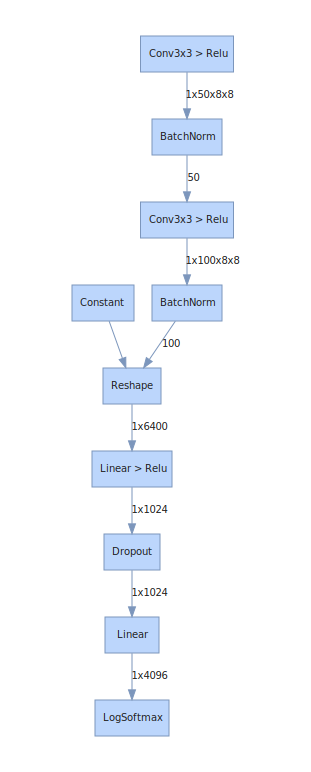

In [110]:
board = chess.Board()
x = create_input(board)
x.unsqueeze_(0)

hl_graph = hl.build_graph(model, x)
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph